In [4]:
### imports
import os
import numpy as np 
import pandas as pd 
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import warnings
warnings.filterwarnings('ignore')    ## I don't like pandas setting with copy warnings 

df = pd.read_excel(r'..\raw_data\CO2.xlsx','Sheet1')

In [17]:
m = {'N Europe':'N Europe', 'Mediterranean area' :'Mediterranean area', 'N America': 'N America', 'Asia':'Asia', "Oceania": 'Oceania', 'S America':'S America',
      'Mediterranean Area':'Mediterranean area', 'Africa':'Africa', 'Central Europe':'Central Europe', 'World':'World', '-':'-' }

df['Region'] = df['Region'].map(m)
df['Region'].value_counts()

Region
N Europe              417
Mediterranean area    190
N America              92
Asia                   80
S America              37
Oceania                37
-                      18
Africa                 10
World                  10
Central Europe          5
Name: count, dtype: int64

In [18]:
food_counts = df.groupby('Food').size()
food_counts.nlargest(20)

Food
MILK            162
BEEF MEAT        68
TOMATOES         46
PASTA            38
POULTRY MEAT     37
BREAD            27
OLIVE OIL        25
POTATOES         25
APPLES           24
EGGS             24
RICE             22
CHEESE           20
CUCUMBERS        19
YOGURT           19
LAMB MEAT        18
CODFISH          16
LETTUCE          13
STRAWBERRIES     13
CARROTS          12
SALMON           12
dtype: int64

In [19]:
def get_types(df, cutoff):
    df = pd.DataFrame(df)
    type_1 = df.index[(df < cutoff).any(axis=1)].tolist()
    type_2 = df.index[(df >= cutoff).any(axis=1)].tolist()
    return type_1, type_2

type_1, type_2 = get_types(food_counts, 10)

In [ ]:
print(f'>>>> Number of type 1 items are: {len(type_1)}')

>>>> Number of type 1 items are: 89


In [21]:
print(f'>>>> Number of type 2 items are: {len(type_2)}')
print(type_2)

>>>> Number of type 2 items are: 23
['APPLES', 'BEANS', 'BEEF MEAT', 'BREAD', 'BUTTER', 'CARROTS', 'CHEESE', 'CODFISH', 'CUCUMBERS', 'EGGS', 'LAMB MEAT', 'LETTUCE', 'MILK', 'OLIVE OIL', 'PASTA', 'POTATOES', 'POULTRY MEAT', 'RICE', 'SALMON', 'STRAWBERRIES', 'TOMATOES', 'TROUT', 'YOGURT']


In [22]:
def check_values_for_region(df, region, type_2: list):
    # Filter the DataFrame for the given region
    df_region = df[df['Region'] == region]
    
    food_counts = df_region.groupby('Food').size()
    food_counts = food_counts[food_counts.index.isin(type_2)]
    type_2A = food_counts[food_counts >= 10].index.tolist()
    type_2B = [x for x in type_2 if x not in type_2A]
    
    return type_2A, type_2B

type_2A, type_2B = check_values_for_region(df,'Mediterranean area', type_2)

In [23]:
print(f'>>>> Number of type 2A items are: {len(type_2A)}')
print(type_2A)

>>>> Number of type 2A items are: 5
['MILK', 'OLIVE OIL', 'PASTA', 'TOMATOES', 'YOGURT']


In [24]:
print(f'>>>> Number of type 2B items are: {len(type_2B)}')
print(type_2B)

>>>> Number of type 2B items are: 18
['APPLES', 'BEANS', 'BEEF MEAT', 'BREAD', 'BUTTER', 'CARROTS', 'CHEESE', 'CODFISH', 'CUCUMBERS', 'EGGS', 'LAMB MEAT', 'LETTUCE', 'POTATOES', 'POULTRY MEAT', 'RICE', 'SALMON', 'STRAWBERRIES', 'TROUT']


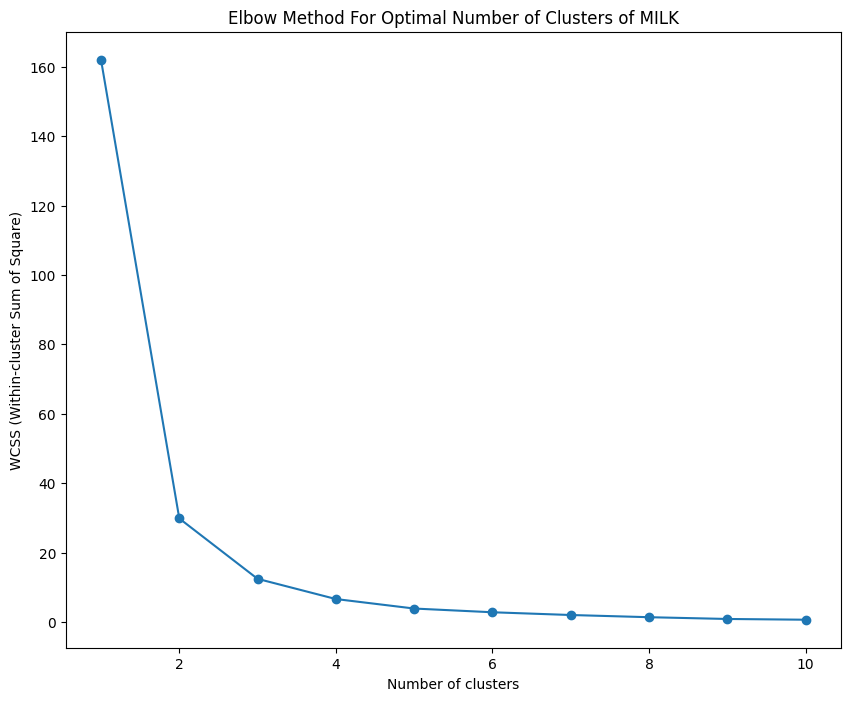

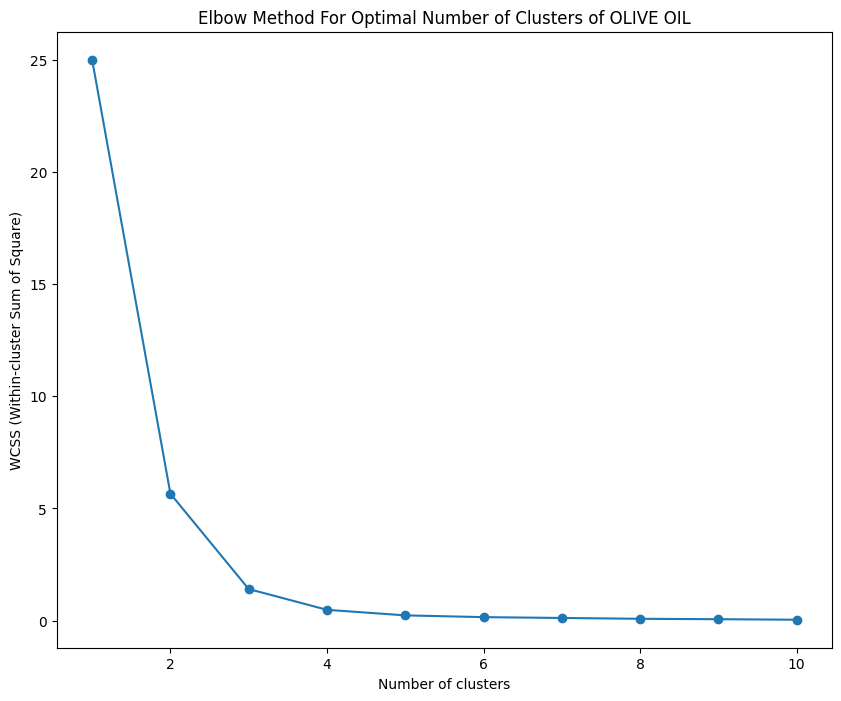

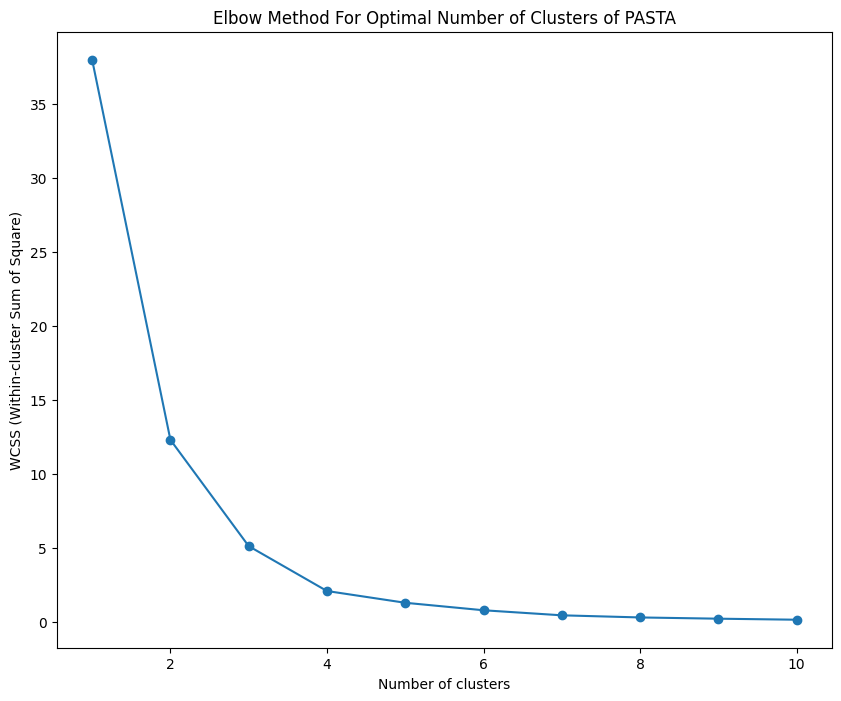

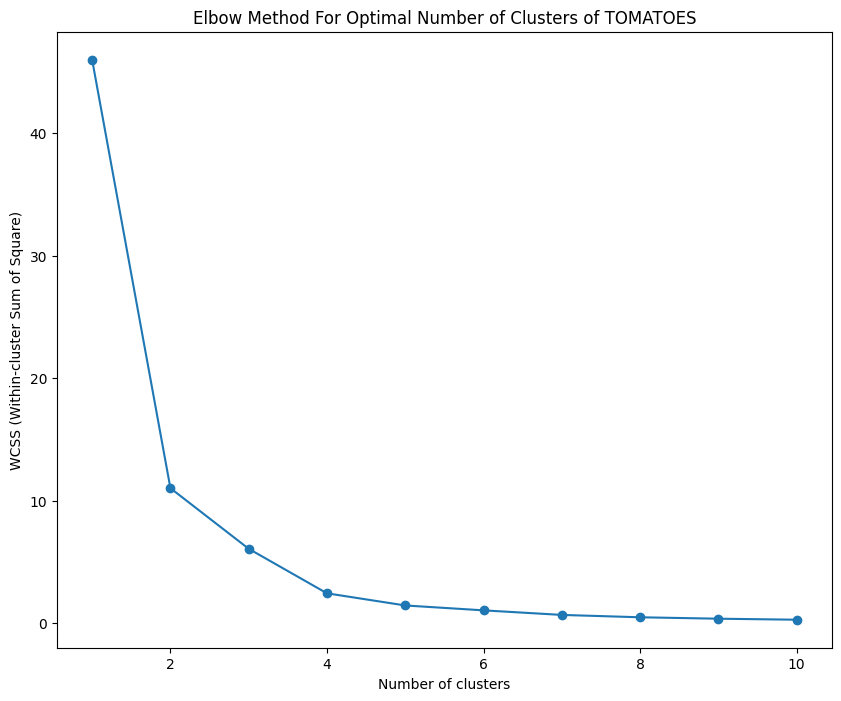

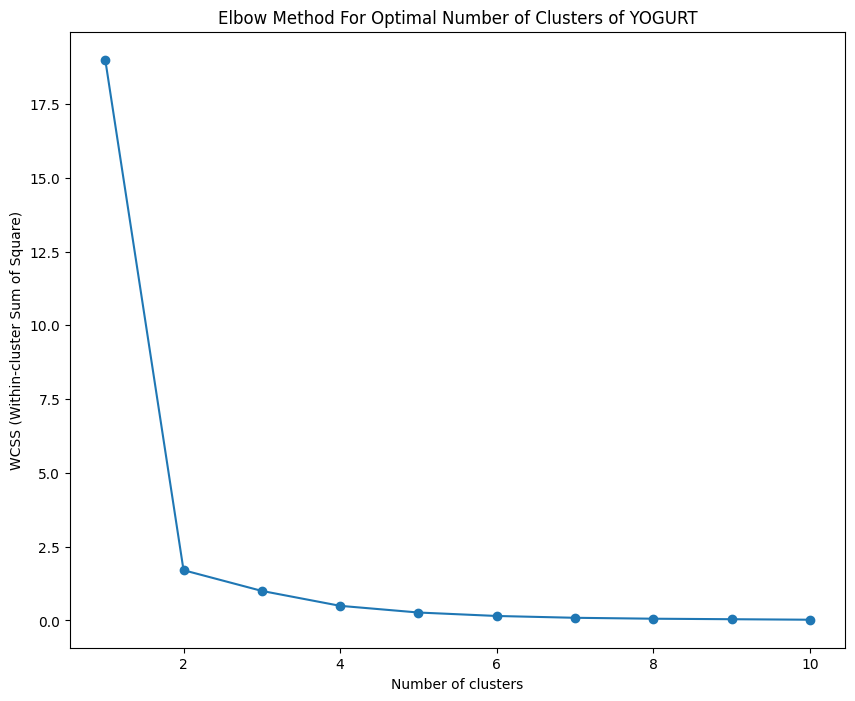

In [25]:

def plot_num_clusters(df,food):
    cf = df[df['Food'] == food]
    cf = cf[['Food','Region','CARBON FOOTPRINT\ng CO2 per kg or l']]
    # Step 3: Preprocessing
    # Standardize the data to normalize the CO2 emissions across different scales
    scaler2 = StandardScaler()
    scaled_data2 = scaler2.fit_transform(cf.iloc[:, 2:])  # Assuming the first column is 'Continent' and the rest are emissions

    # Step 4: Applying K-Means Clustering
    # Determine the optimal number of clusters using the Elbow method
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(scaled_data2)
        wcss.append(kmeans.inertia_)

    # Plotting the Elbow graph to find the optimal number of clusters
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title(f'Elbow Method For Optimal Number of Clusters of {food}')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS (Within-cluster Sum of Square)')
    plt.show()

for i in type_2A:
    plot_num_clusters(df, i)

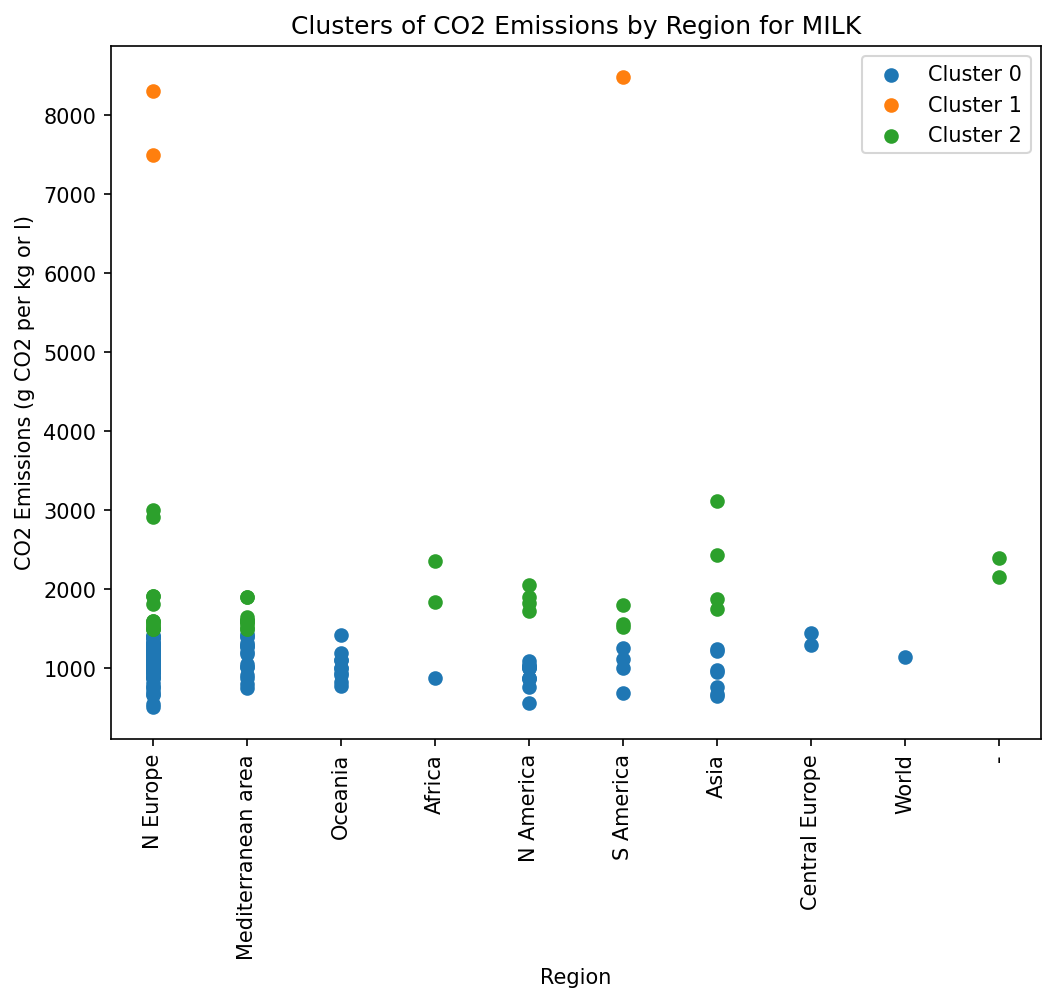

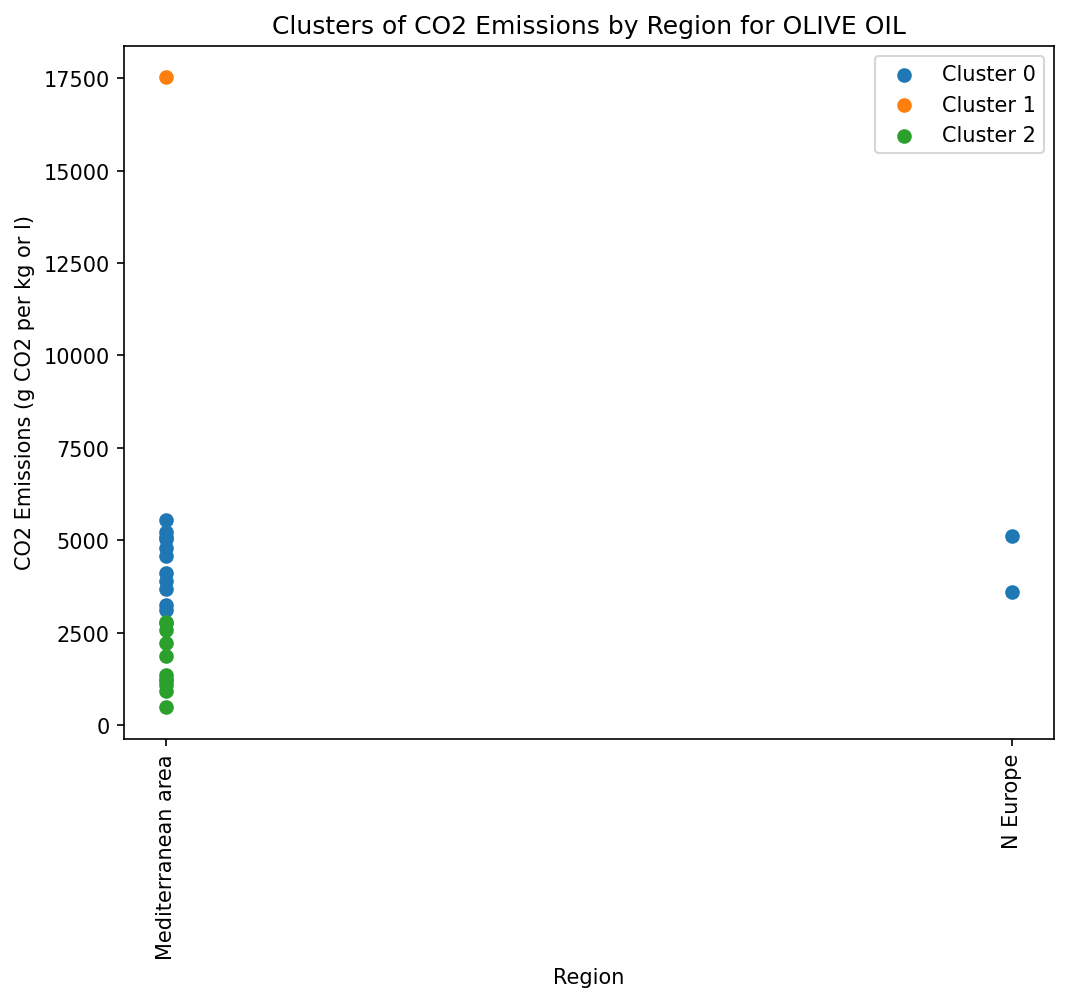

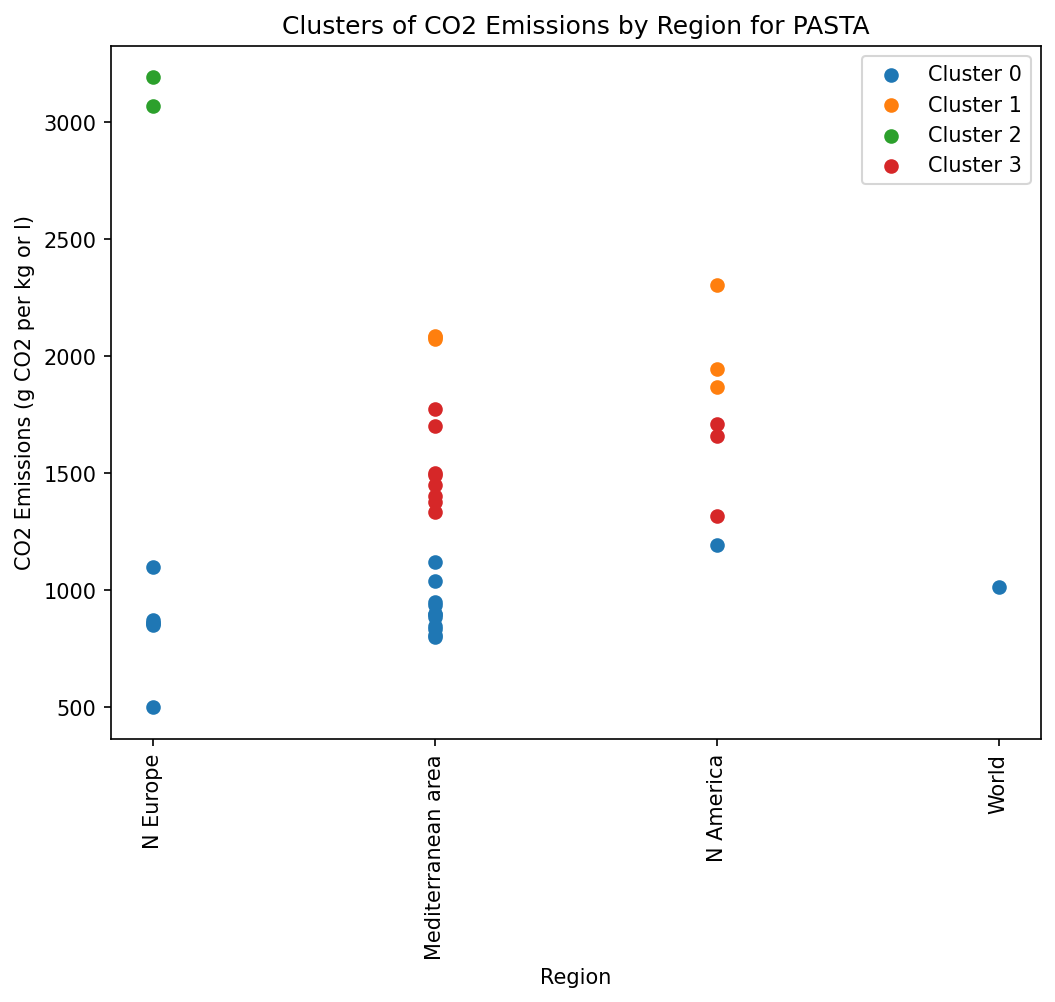

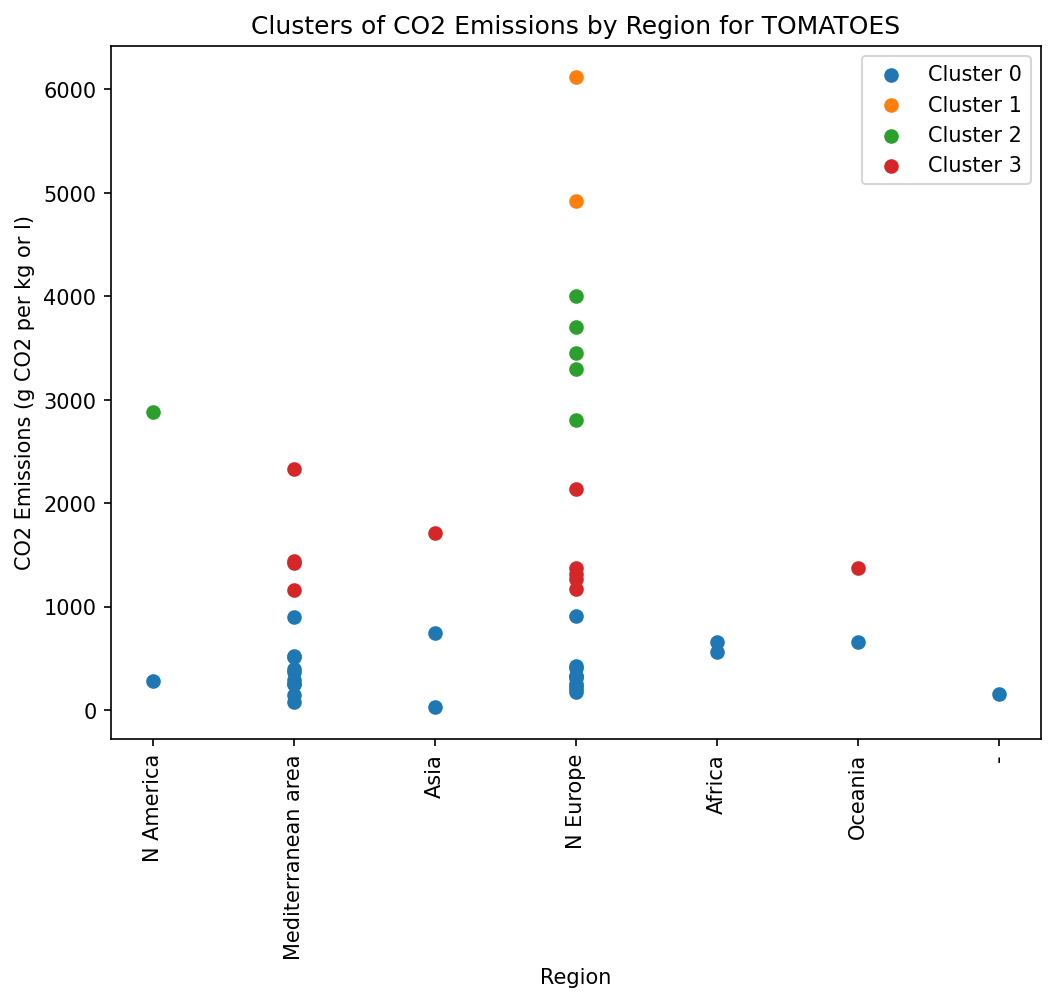

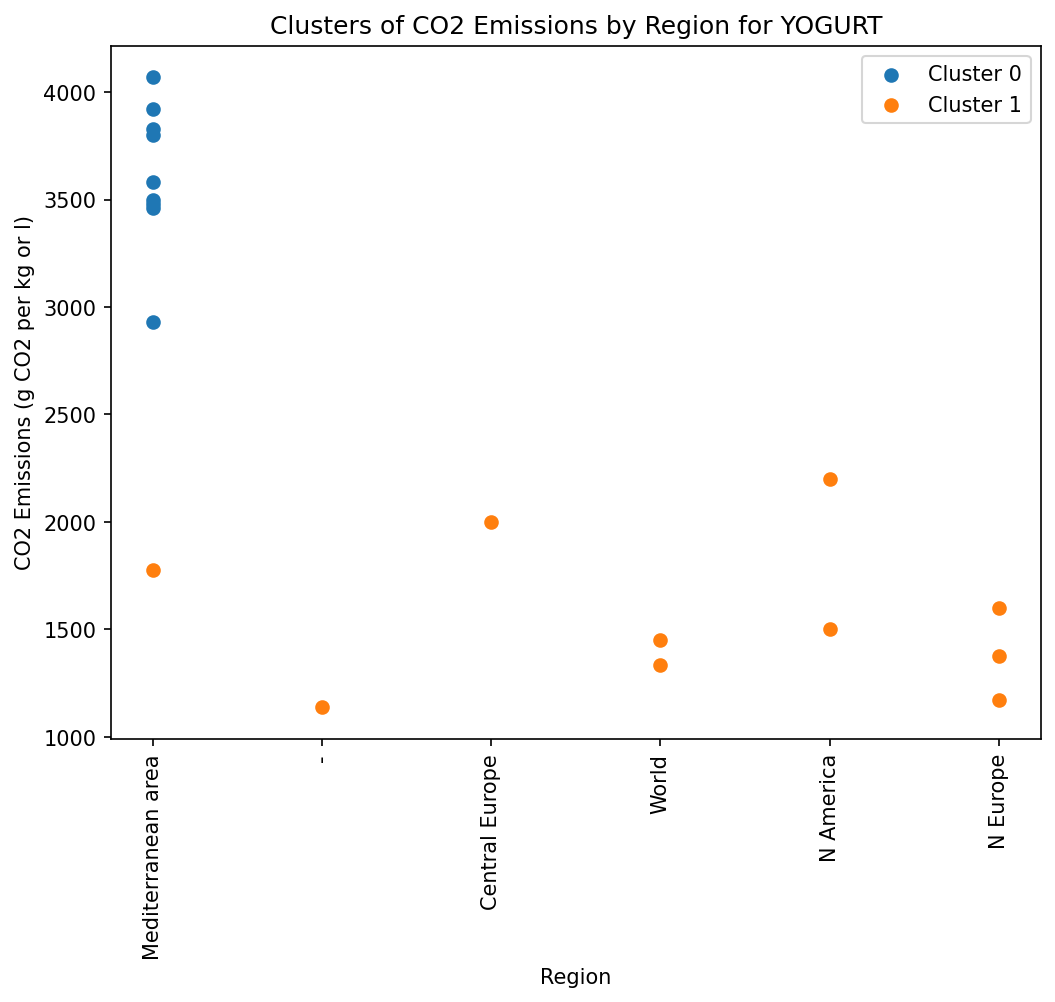

In [ ]:
def plot_clusters(df, food, n):
    optimal_clusters = n
    # Filter data
    cf = df[df['Food'] == food].copy()
    cf = cf[['Food', 'Region', 'CARBON FOOTPRINT\ng CO2 per kg or l']]
    cf.rename(columns={'CARBON FOOTPRINT\ng CO2 per kg or l': 'CO2'}, inplace=True)

    # Standardize data
    scaler2 = StandardScaler()
    scaled_data2 = scaler2.fit_transform(cf[['CO2']])

    # Fit K-Means
    kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    clusters = kmeans.fit_predict(scaled_data2)

    # Add clusters to dataframe
    cf['Cluster'] = clusters
    cf['CO2'] = cf['CO2'].astype(float)

    # Plot clusters
    plt.figure(figsize=(8, 6), dpi=150)
    plt.xticks(rotation=90)
    for cluster in range(optimal_clusters):
        cluster_data = cf[cf['Cluster'] == cluster]
        plt.scatter(cluster_data['Region'], cluster_data['CO2'], label=f'Cluster {cluster}')
    
    plt.title(f'Clusters of CO2 Emissions by Region for {food}')
    plt.xlabel('Region')
    plt.ylabel('CO2 Emissions (g CO2 per kg or l)')
    plt.legend()
    plt.show()

    return cf

# Ensure the output directory exists
output_dir = 'task1'
os.makedirs(output_dir, exist_ok=True)

# Define the number of clusters for each food item
num_clusters = {'MILK': 3, 'OLIVE OIL': 3, 'PASTA': 4, 'TOMATOES': 4, 'YOGURT': 2}

# Store processed datasets in a dictionary
datasets = {}

# Process and save datasets
for food, clusters in num_clusters.items():
    datasets[food] = plot_clusters(df, food, clusters)
    output_file = os.path.join(output_dir, f"{food.lower().replace(' ', '_')}.xlsx")
    datasets[food].groupby('Region').agg({'CO2': 'mean'}).round(2).to_excel(output_file)



### olive oil and yougurt each had an outlier value 


In [27]:
# cleaned estimations after outlier remaval 

olive_data = datasets['OLIVE OIL'].drop(876, axis=0)
olive_data.groupby('Region').agg({'CO2': 'mean'}).round(2).to_excel(os.path.join(output_dir, 'olive_oil_cleaned.xlsx'))

yogurt_data = datasets['YOGURT'].drop(191, axis=0)
yogurt_data.groupby('Region').agg({'CO2': 'mean'}).round(2).to_excel(os.path.join(output_dir, 'yogurt_cleaned.xlsx'))

In [28]:
avg_df = df[df['Food'].isin(type_1)]
avg_df['CO2'] = pd.to_numeric(avg_df['CARBON FOOTPRINT\ng CO2 per kg or l'], errors='coerce').astype(float)
print(len(avg_df))
avg_df.dropna(subset=['CO2'],inplace=True)
print(len(avg_df))
means = avg_df.groupby('Food').agg({'CO2':'mean'}).round(2)
means.to_excel('task1/type_1.xlsx')

224
224


In [ ]:
# Huber Estimator Function
def do_huber(data, maxiter=3000):
    """
    Calculate Huber's robust location estimator for an array of data.
    
    Parameters:
    data : array-like
        Input data values.
    maxiter : int, optional
        Maximum number of iterations (default is 3000).
    
    Returns:
    float
        The Huber estimator of the central location.
    """
    huber = sm.robust.scale.Huber(c=1.3, maxiter=maxiter)
    loc, scale = huber(data)
    return loc

# Tukey's Biweight Estimator Function
def tukey_biweight(data, c=4.685):
    """
    Tukey's biweight estimator for robust central location.
    
    Parameters:
    data : array-like
        Input data values.
    c : float, optional
        Tuning constant (default is 4.685).
    
    Returns:
    float
        The Tukey biweight estimate of the central location.
    """
    data = np.asarray(data)
    median = np.median(data)
    mad = np.median(np.abs(data - median))  # Median Absolute Deviation (MAD)
    
    if mad == 0:  # Handle constant data case
        return median
    
    # Calculate standardized residuals
    u = (data - median) / (c * mad)
    
    # Weighting function (Tukey's biweight)
    w = (1 - u**2)**2
    w[np.abs(u) >= 1] = 0  # Set weight to 0 for values beyond the cutoff
    
    if np.sum(w) == 0:
        return median
    
    # Tukey's biweight estimate
    biweight_estimate = np.sum((data - median) * w) / np.sum(w)
    
    return biweight_estimate + median

def calculate_statistics(food):
    """
    Calculates Huber estimator, Tukey biweight, mean, and median for a given food's data.
    
    Parameters:
    food : str
        Food name to filter the DataFrame.
    
    Returns:
    dict
        Dictionary with food name, Huber, Tukey, mean, and median values.
    """
    food_df = df[df['Food'] == food]
    arr = food_df['CARBON FOOTPRINT\ng CO2 per kg or l']
    data = pd.to_numeric(arr, errors='coerce').dropna()  # Convert to numeric and drop NaN values
    
    # If the data is empty, return NaN values
    if len(data) == 0:
        return {'Food': food, 'Huber': np.nan, 'Tukey': np.nan, 'Mean': np.nan, 'Median': np.nan}
    
    try:
        huber_val = do_huber(data)
    except Exception as e:
        huber_val = np.nan
    
    try:
        tukey_val = tukey_biweight(data)
    except Exception as e:
        tukey_val = np.nan
    
    return {
        'Food': food,
        'Huber': huber_val,
        'Tukey': tukey_val,
        'Mean': np.mean(data),
        'Median': np.median(data)
    }

# Assuming type_2B contains the list of food items
results = []

# Loop through the list of food types and calculate statistics for each
for i in type_2B:   
    result = calculate_statistics(i)
    results.append(result)  # Append the result to the results list

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results).round(3)

# Output the resulting DataFrame
print(results_df)

            Food               Huber      Tukey       Mean     Median
0         APPLES   258.3292427895005    205.223    287.766    200.000
1          BEANS   703.9063049567173    682.716    722.137    680.000
2      BEEF MEAT  17899.758844651064  17182.559  19613.293  17850.000
3          BREAD  1013.0744524941539    963.256   1039.853    907.582
4         BUTTER   8718.223295406062   8405.635  10341.885   8800.000
5        CARROTS   264.9461423038453    195.914    372.852    217.000
6         CHEESE   9120.984054942799   8798.123   9302.488   8797.000
7        CODFISH  2744.3055545228226   2691.285   2776.979   2675.000
8      CUCUMBERS   825.0649045155529    271.429    999.025    351.562
9           EGGS    3101.79532762885   3104.980   3112.812   3110.000
10     LAMB MEAT   13280.94623361076  14420.279  13523.241  14722.222
11       LETTUCE   353.0706015249709    296.383    841.148    325.000
12      POTATOES  171.80448048034535    151.420    181.192    160.000
13  POULTRY MEAT  32

In [30]:
results_df.to_excel('task1/type_2B.xlsx')

Added all of the items to All.xlsx... for next steps